Importing the libraries

In [96]:
import sklearn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import preprocessing
import numpy as np

Read data file

In [97]:
df = pd.read_csv("out_without_nan_mood_normalised_extra_temp_train.csv")
clf = LinearRegression()

Add dummies, remove weekDay mean, remove day mean

In [98]:
df['mood_mean_TARGET'] = df['mood_mean_TARGET'].astype(float)
df = pd.concat([df,pd.get_dummies(df['id'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['weekDay'],prefix="day_")],axis=1)
df = df.drop(['weekDay_time_5','day_time_5','weekDay_time_4','day_time_4','weekDay_time_3','day_time_3','weekDay_time_2','day_time_2','weekDay_time_1','day_time_1','weekDay_time_5','mood_mean_time_1','circumplex.valence_mean_time_1'],axis=1)
df = df.fillna(0)
df = df.loc[:, (df != 0).any(axis=0)]

In [99]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr) and corr_matrix.columns[i] != "mood_mean_TARGET" and corr_matrix.columns[j] != "mood_mean_TARGET":
                
                colnameI = corr_matrix.columns[i]
                colnameJ = corr_matrix.columns[j]
                if abs(corr_matrix.mood_mean_TARGET[colnameI]) > abs(corr_matrix.mood_mean_TARGET[colnameJ]):
                    colname = colnameJ
                else:
                    colname = colnameI
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    
    return(dataset)

#correlation(df,0.7) #Won't do this since it isn't actually needed


In [100]:
corr=df.corr()
goodColumns= corr[abs(corr['mood_mean_TARGET'])>0.25]['mood_mean_TARGET'].sort_values()
goodColumns = goodColumns.drop(['mood_mean_TARGET'])
print(goodColumns)


numberOfTimesSeenMood5Days_5     -0.309945
numberOfTimesSeenMood5Days_4     -0.304778
AS14.07                          -0.284923
lastTimeSeenMood_7               -0.284289
circumplex.valence_mean_time_3    0.258131
circumplex.valence_mean_time_2    0.275123
circumplex.valence_mean           0.287016
mood_mean                         0.487427
mood_mean_time_3                  0.504293
mood_mean_time_2                  0.511067
mood_mean_time_4                  0.512087
mood_mean_time_5                  0.519371
Name: mood_mean_TARGET, dtype: float64


In [101]:
notRelevantAll=df.drop(['id','date'],axis=1).dropna()
goldY= notRelevantAll['mood_mean_TARGET']
relevant = notRelevantAll.drop(['mood_mean_TARGET'],axis=1)

In [102]:
scoring = {'R2': 'r2',
           'Mean squared Error': 'neg_mean_squared_error',
           'Explained variance': 'explained_variance'}

scores = cross_validate(clf, relevant[goodColumns.keys()], goldY, cv=7,scoring=scoring)
print("R2: %0.2f (+/- %0.2f)" % (scores['test_R2'].mean(), scores['test_R2'].std() * 2))
print("MSE: %0.2f (+/- %0.2f)" % (scores['test_Mean squared Error'].mean(), scores['test_Mean squared Error'].std() * 2))
print("EXPLAINED VARIANCE: %0.2f (+/- %0.2f)" % (scores['test_Explained variance'].mean(), scores['test_Explained variance'].std() * 2))


R2: 0.27 (+/- 0.15)
MSE: -0.39 (+/- 0.21)
EXPLAINED VARIANCE: 0.29 (+/- 0.17)


Evaluate on real test set

In [103]:
clf.fit(relevant[goodColumns.keys()], goldY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [104]:
dfTest = pd.read_csv("out_without_nan_mood_normalised_extra_temp_test.csv")
dfTest['mood_mean_TARGET'] = dfTest['mood_mean_TARGET'].astype(float)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['id'])],axis=1)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['weekDay'],prefix="day_")],axis=1)

MAE
0.46883653626876887
MSE
0.3837113522382853
RMSE
0.6194443899481901
R2
0.25949503123791406
[('numberOfTimesSeenMood5Days_5', -0.2831431690240392), ('numberOfTimesSeenMood5Days_4', -0.07888628443047128), ('AS14.07', -0.3985265858616264), ('lastTimeSeenMood_7', -0.01572978299963433), ('circumplex.valence_mean_time_3', 0.19280186312153264), ('circumplex.valence_mean_time_2', -0.6356772355453106), ('circumplex.valence_mean', 0.25406534905016265), ('mood_mean', 0.9100693188446287), ('mood_mean_time_3', -1.122173483399908), ('mood_mean_time_2', 1.5658383569285583), ('mood_mean_time_4', -0.5632312538722019), ('mood_mean_time_5', 2.2649535752867807)]


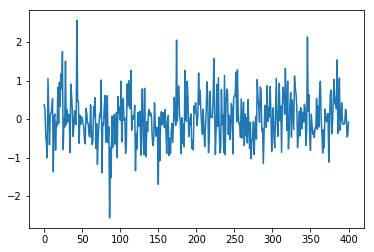

In [105]:
y_pred =clf.predict(dfTest[goodColumns.keys()])
print("MAE")
print(metrics.mean_absolute_error(dfTest['mood_mean_TARGET'],y_pred))
print("MSE")
print(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred))
print("RMSE")
print(np.sqrt(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred)))
print("R2")
print(metrics.r2_score(dfTest['mood_mean_TARGET'],y_pred))


print(list(zip(goodColumns.keys(),clf.coef_)))
import matplotlib.pyplot as plt
plt.plot(y_pred-dfTest['mood_mean_TARGET'])
plt.show()

In [88]:
df.columns.values

array(['id', 'date', 'activity_mean', 'circumplex.arousal_mean',
       'circumplex.valence_mean', 'mood_mean', 'appCat.builtin_sum',
       'appCat.communication_sum', 'appCat.entertainment_sum',
       'appCat.finance_sum', 'appCat.game_sum', 'appCat.office_sum',
       'appCat.other_sum', 'appCat.social_sum', 'appCat.travel_sum',
       'appCat.unknown_sum', 'appCat.utilities_sum', 'appCat.weather_sum',
       'call_sum', 'screen_sum', 'sms_sum', 'day', 'weekDay',
       'activity_mean_time_1', 'circumplex.arousal_mean_time_1',
       'circumplex.valence_mean_time_1', 'appCat.builtin_sum_time_1',
       'appCat.communication_sum_time_1',
       'appCat.entertainment_sum_time_1', 'appCat.finance_sum_time_1',
       'appCat.game_sum_time_1', 'appCat.other_sum_time_1',
       'appCat.social_sum_time_1', 'appCat.travel_sum_time_1',
       'appCat.unknown_sum_time_1', 'appCat.utilities_sum_time_1',
       'appCat.weather_sum_time_1', 'call_sum_time_1',
       'screen_sum_time_1', 'sms_su